# You have csv files provided in the folder that you can use if you are stuck and can't get it through code on your own but if you use it since it's a big hint you will have a point deduction

# Part 1: Correlation of Future Orientation Index and Gross Domestic Product
## Tasks

In this exercise, we try to reproduce the findings of the article “Quantifying the Advantage of Looking Forward” http://www.nature.com/articles/srep00350.

According to the study, the GDP per capita of countries is positively correlated to how much their population searches in Google for the next year, relative to how much they search for the previous year.

This ratio is called the Future Orientation Index (FOI). So for example for the year 2017 the FOI can be calculated as: FOI = number of searches for the term “2018” / number of searches for the term “2016”.

You will do the following tasks:
1. Aquire World Bank Data
2. Calculate the Future Orientation Index in Google Trends
3. Test the correlation between GDP and FOI

### Install requirements. 

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  
* [`wbgapi`](https://github.com/tgherzog/wbgapi) is a Python package which provides modern, pythonic access to the World Bank's data API. [Here](https://github.com/tgherzog/wbgapi) is the documentation of `wbgapi`.
* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python package for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.
* [`matplotlib`](https://matplotlib.org/) is a Python package for creating plots. [Here](https://matplotlib.org/stable/api/index.html) is the documentation of `matplotlib`.
* [`scipy`](https://scipy.org/) is a Python package with different algorithms for scientific computing. [Here](https://docs.scipy.org/doc/scipy/reference/index.html#scipy-api) is the documentation of `scipy`.

In [24]:
! pip install wbgapi
! pip install pandas
! pip install matplotlib
! pip install scipy

### Import requirements
The cell below imports all necessary dependancies. Make sure they are installed (see cell above).

In [25]:
import wbgapi as wb
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# 1 World Bank Data
## 1.1 Download WDI data

From the WDI we need three indicators:
* Gross Domestic Product (GDP) per capita corrected by the Purchase Power Parity (PPP in current or 2005 international $, `"NY.GDP.PCAP.PP.KD"`)
* The amount of Internet users (per 100 people, `"IT.NET.USER.ZS"`
* The total population (described as as "Population, Total", `"SP.POP.TOTL"`)

In the following code chunk, download all data (including extras) for all countries in year 2014 and save it as a pandas data frame. See [here](https://github.com/tgherzog/wbgapi#accessing-data) how to use the `data` subpackage of `wbgapi`.

Hint: To remove aggregates (economic regions defined by the World Bank) and include only countries, use `skipAggs=True`.

In [48]:
wb_data = wb.data.DataFrame(['NY.GDP.PCAP.PP.KD', 'IT.NET.USER.ZS', 'SP.POP.TOTL'], time=2015, skipAggs=True, labels=True).reset_index()
wb_data

,economy,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
0,ZWE,Zimbabwe,22.7428,3584.098151,14154937.0
1,ZMB,Zambia,8.8000,3610.135921,16248230.0
2,YEM,"Yemen, Rep.",24.0854,NaN,28516545.0
3,PSE,West Bank and Gaza,56.7000,6072.650318,4270092.0
4,VIR,Virgin Islands (U.S.),54.8391,42584.153139,107712.0
...,...,...,...,...,...
212,AND,Andorra,87.9000,62476.065755,71746.0
213,ASM,American Samoa,NaN,NaN,51368.0
214,DZA,Algeria,38.2000,15425.940521,39543154.0
215,ALB,Albania,56.9000,13234.144060,2880703.0


Now drop any row that has `NaN` for this you can use `pandas` [`dropna`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html) method.

In [49]:
wb_data = wb_data.dropna()
wb_data

,economy,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL
0,ZWE,Zimbabwe,22.7428,3584.098151,14154937.0
1,ZMB,Zambia,8.8000,3610.135921,16248230.0
3,PSE,West Bank and Gaza,56.7000,6072.650318,4270092.0
4,VIR,Virgin Islands (U.S.),54.8391,42584.153139,107712.0
5,VNM,Viet Nam,45.0000,9311.407525,92191398.0
...,...,...,...,...,...
211,AGO,Angola,22.0000,9991.602500,28127721.0
212,AND,Andorra,87.9000,62476.065755,71746.0
214,DZA,Algeria,38.2000,15425.940521,39543154.0
215,ALB,Albania,56.9000,13234.144060,2880703.0


Next only keep rows where there are at least 5 Million internet users. Keep in Mind that the Internet Users are per 100 people, so don't forget to take the population into account.

For example in the dataset Austria has 80.995825 internet users per 100 people, while 8546356 people living in Austria. This means Austria has 6922191.55 internet users in total. The calculation for that is as follows:
$
\begin{align}
internet\_users = population \cdot \frac{internet\_user\_per\_100}{100}
\end{align}
$


In [51]:
# calculate total number of internet users
wb_data = wb_data.assign(internet_user=wb_data['SP.POP.TOTL'] * wb_data['IT.NET.USER.ZS'] / 100)
# keep rows where there are at least 5 Million internet users
wb_data = wb_data.loc[wb_data['internet_user'] >= 5e+06]
wb_data

,economy,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL,internet_user
5,VNM,Viet Nam,45.0000,9311.407525,92191398.0,4.148613e+07
8,UZB,Uzbekistan,42.8000,6697.922619,31298900.0,1.339593e+07
10,USA,United States,74.5542,64599.573736,320738994.0,2.391244e+08
11,GBR,United Kingdom,92.0003,51776.248985,65116219.0,5.990712e+07
12,ARE,United Arab Emirates,90.5000,66992.240145,8916899.0,8.069794e+06
...,...,...,...,...,...,...
205,AUT,Austria,83.9401,62309.394270,8642699.0,7.254690e+06
206,AUS,Australia,84.5605,55015.296479,23815995.0,2.013892e+07
209,ARG,Argentina,68.0431,28905.761348,43131966.0,2.934833e+07
211,AGO,Angola,22.0000,9991.602500,28127721.0,6.188099e+06


# 2 The Future Orientation Index in Google Trends
## 2.1 Download data from Google Trends

You can download the data from Google Trends following these steps:

1) Log out from your google account or set its language to English

2) Go to trends.google.com and search for 2013 

3) Add 2015 as a search term

4) Select custom time rage: full year: 2014

5) Set the region to “Worldwide”. You can also try with this link (it links to the google trends page with all settings from above applied): https://trends.google.com/trends/explore?date=2014-01-01%202014-12-31&q=2013,2015

6) Go to the map at “Compared breakdown by region” and tick on “include low search volume regions”

7) On the top right menu click the download button to get a geoMap.csv file

If you have problems getting the file from the web interface, we also included it in the github repository.

Load the .csv file in a pandas data frame. Notice in the file the first 3 Lines are actually only information (while the third is the header). You can skip these lines by using `skiprows=3` in `pd.read_csv`. Set the headers to `"Country", "G2013", "G2015"`, this can be done by the keyword argument `names` in `pd.read_csv`.

Now remove again all rows containing `NaN`.

All the percentage data is saved as a string containing the `%` symbol. You can remove this with `pandas` [`str.replace`](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html) method and save them as integer with `pandas` [`astype`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html) method. Do this for column `G2013` and `G2015`.


In [58]:
# Load the .csv file in a pandas data frame
gt_data = pd.read_csv('geoMap.csv', skiprows=3, names=['Country', 'G2013', 'G2015'])
# Remove all rows containing NaN
gt_data = gt_data.dropna()
# Remove % symbol and convert value to int
gt_data['G2013'] = gt_data['G2013'].str.replace('%', '')
gt_data['G2015'] = gt_data['G2015'].str.replace('%', '')
gt_data['G2013'] = gt_data['G2013'].astype(int)
gt_data['G2015'] = gt_data['G2015'].astype(int)
gt_data

,Country,G2013,G2015
0,Algeria,67,33
1,Moldova,87,13
2,Armenia,85,15
3,Pakistan,84,16
5,Kazakhstan,81,19
...,...,...,...
229,Malawi,64,36
230,South Korea,71,29
231,Taiwan,61,39
232,South Sudan,67,33


## 2.2 Calculate the Future Orientation Index

In the following code chunk, make a new column in the Google Trends dataframe with the Future Orientation Index, which is the ratio between the search volume for 2015 and 2013 in 2014 for each country

In [56]:
# calculate foi
gt_data = gt_data.assign(foi=gt_data['G2015'] / gt_data['G2013'])
gt_data

,Country,G2013,G2015,foi
0,Algeria,67,33,0.492537
1,Moldova,87,13,0.149425
2,Armenia,85,15,0.176471
3,Pakistan,84,16,0.190476
5,Kazakhstan,81,19,0.234568
...,...,...,...,...
229,Malawi,64,36,0.562500
230,South Korea,71,29,0.408451
231,Taiwan,61,39,0.639344
232,South Sudan,67,33,0.492537


## 2.3 Merge with World Bank data

Merge the WDI and google trends data frames, using the name of the country. For this you can use `pandas` [`merge`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html) method.

In [57]:
data = wb_data.merge(right=gt_data, on='Country')
data

,economy,Country,IT.NET.USER.ZS,NY.GDP.PCAP.PP.KD,SP.POP.TOTL,internet_user,G2013,G2015,foi
0,UZB,Uzbekistan,42.8000,6697.922619,3.129890e+07,1.339593e+07,73,27,0.369863
1,USA,United States,74.5542,64599.573736,3.207390e+08,2.391244e+08,57,43,0.754386
2,GBR,United Kingdom,92.0003,51776.248985,6.511622e+07,5.990712e+07,55,45,0.818182
3,ARE,United Arab Emirates,90.5000,66992.240145,8.916899e+06,8.069794e+06,68,32,0.470588
4,UKR,Ukraine,48.8846,15625.728516,4.516735e+07,2.207988e+07,77,23,0.298701
5,TUN,Tunisia,46.5000,12518.424945,1.155778e+07,5.374367e+06,74,26,0.351351
6,THA,Thailand,39.3161,18877.266477,7.029440e+07,2.763702e+07,74,26,0.351351
7,TZA,Tanzania,10.0000,3080.541260,5.254282e+07,5.254282e+06,87,13,0.149425
8,CHE,Switzerland,87.4791,77257.682333,8.282396e+06,7.245365e+06,51,49,0.960784
9,SWE,Sweden,90.6102,59593.859029,9.799186e+06,8.879062e+06,61,39,0.639344


# 3 Testing the correlation between GDP and FOI
# 3.1 Visualize FOI vs GDP

Now that you have the FOI index, GPD per capita and PPP value for each country, you can make a scatter plot of FOI vs GDP.

For this you can use the [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) method of `matplotlib`.

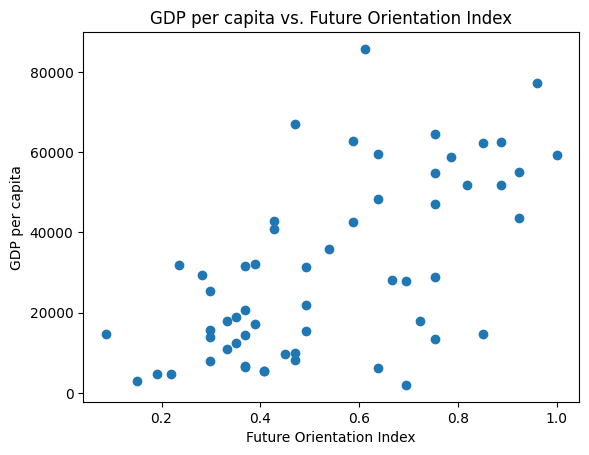

In [59]:
plt.scatter(data['foi'], data['NY.GDP.PCAP.PP.KD'])
plt.title('GDP per capita vs. Future Orientation Index')
plt.xlabel('Future Orientation Index')
plt.ylabel('GDP per capita')
plt.show()


## 3.2 Measure Pearson’s correlation

In the following chunk, calculate Pearson’s correlation coefficient between GDP and FOI.

For this you can use the [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) method of `scipy`.

In [64]:
pearson_2014 = stats.pearsonr(data['foi'], data['NY.GDP.PCAP.PP.KD'])
print(pearson_2014)
print(f'The Pearson correlation coefficient is {pearson_2014.statistic}, indicating a moderate positive relationship,\nand the p-value of {pearson_2014.pvalue} suggests this result is statistically significant.')

PearsonRResult(statistic=0.6210588471638042, pvalue=1.9766345158785167e-07)
The Pearson correlation coefficient is 0.6210588471638042, indicating a moderate positive relationship,
and the p-value of 1.9766345158785167e-07 suggests this result is statistically significant.


## 3.3 Measure correlation after shuffling

What happens if we permute the data (e.g. shuffle the FOIs) and repeat the above analysis? Do you find any difference between the two plots and two Pearson’s correlation coefficients?

For the shuffeling you can use `pandas` [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) method with `frac` set to 1.

This test shows you if the correlation is happend by random.

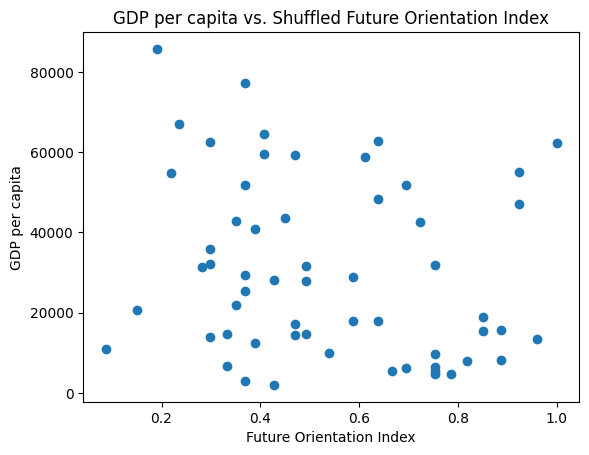

PearsonRResult(statistic=-0.20979632354550445, pvalue=0.11396338444096168)
The Pearson correlation coefficient is -0.20979632354550445, indicating a very weak positive relationship,
and the p-value of 0.11396338444096168 suggests the result is not statistically significant.
Therefore the original correlation is very likely not random.


In [70]:
data_shuffled = data
data_shuffled['foi'] = data_shuffled['foi'].sample(frac=1).values

plt.scatter(data_shuffled['foi'], data_shuffled['NY.GDP.PCAP.PP.KD'])
plt.title('GDP per capita vs. Shuffled Future Orientation Index')
plt.xlabel('Future Orientation Index')
plt.ylabel('GDP per capita')
plt.show()

pearson_shuffled = stats.pearsonr(data_shuffled['foi'], data_shuffled['NY.GDP.PCAP.PP.KD'])
print(pearson_shuffled)
print(f'The Pearson correlation coefficient is {pearson_shuffled.statistic}, indicating a very weak positive relationship,\nand the p-value of {pearson_shuffled.pvalue} suggests the result is not statistically significant.')
print('Therefore the original correlation is very likely not random.')

Repeat the calculation with 1000 permutations and plot the histogram of the resulting values. Add a line with the value of the correlation without permutation. Is it far or close to the permuted values?

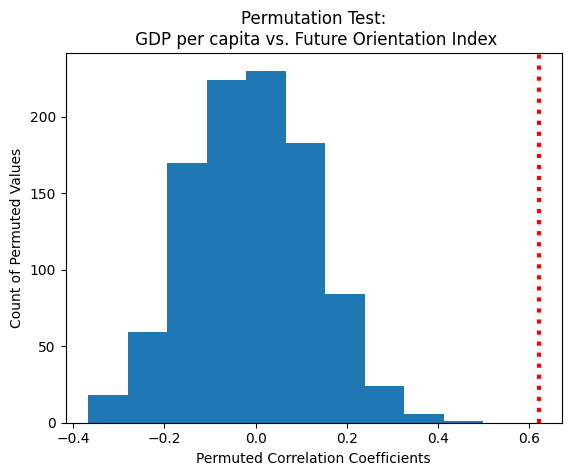

In [73]:
# Permutation Test
data_shuffled = data
pearson_statistics = []
pearson_pvalues = []

for i in range(0, 999):
    data_shuffled['foi'] = data_shuffled['foi'].sample(frac=1).values
    pearson_shuffled = stats.pearsonr(data_shuffled['foi'], data_shuffled['NY.GDP.PCAP.PP.KD'])
    pearson_statistics.append(pearson_shuffled.statistic)
    pearson_pvalues.append(pearson_shuffled.pvalue)
    i += 1

# correlation coefficients
plt.hist(pearson_statistics)
plt.axvline(pearson_2014.statistic, color='r', linestyle = 'dotted', linewidth=3)
plt.title('Permutation Test:\n GDP per capita vs. Future Orientation Index')
plt.xlabel('Permuted Correlation Coefficients')
plt.ylabel('Count of Permuted Values')
plt.show()


The permutation test shows a Gaussian distribution of correlation coefficients ranging approximately from -0.4 to 0.4. The coefficient above 0.6 lies far outside this range, further supporting the assumption that it is not a random correlation.

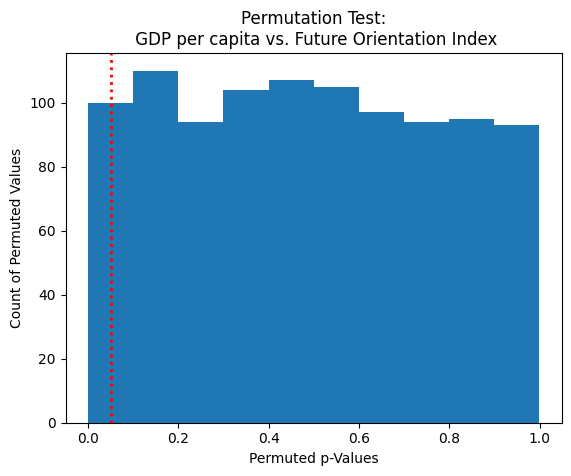

49


In [76]:
# p-Values
plt.hist(pearson_pvalues)
plt.axvline(0.05, color='r', linestyle = 'dotted', linewidth=2)
plt.title('Permutation Test:\n GDP per capita vs. Future Orientation Index')
plt.xlabel('Permuted p-Values')
plt.ylabel('Count of Permuted Values')
plt.show()

significant = 0

for j in range (0, 999):
    if pearson_pvalues[j] <= 0.05:
        significant += 1

print (significant)

The p-values of the permutation test are approximately uniformly distributed between 0 and 1. Only 49 values, or less than 5%, fall below the threshold of 0.05. This proportion is typical for random correlations. This result further supports the assumption that the observed correlation is not due to chance.

# To learn more
### Check robustness
* What result do you get if you use other years? What if you choose one of the earliest years in Google trends?
* How do results change if you use a different threshod instead of 5 Million Internet users?
    
### Test other hypotheses
* Is future orientation generating wealth? Or is wealth enabling to look more to the future?
* Is the FOI really measuring orientation to the future? Could it be something else?

# Part 2: Using Google Trends data to model Flu Trends

## Tasks

Use the [pytrends module](https://pypi.org/project/pytrends/) to get weekly Google Trends data concerning the Flu/Influenza virus from the beginning of 2014 until the end of 2018.

***Hint:*** *the pytrends module currently has a bug. If you get a `TooManyRequestsError` despite following the documentation, try following the advice outlined [here](https://github.com/GeneralMills/pytrends/issues/573#issuecomment-1501897119) or [here](https://github.com/GeneralMills/pytrends/issues/561#issuecomment-1462899426) (both solve the issue).*

### Install requirements. 

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  
* [`pytrends`]((https://pypi.org/project/pytrends/)
* [`requests`]
* [`statsmodels`]

In [78]:
! pip install -U pytrends
! pip install requests
! pip install statsmodels

# 1 Google Trends data

## 1.1 Get weekly Google Trends data concerning the Flu/Influenza virus

- Create an instance of the `TrendReq` class
- Find the appropriate query term (i.e., influenza). The TrendReq class includes a method `suggestions`, which should help you in this task (the query term can look like e.g. `/m/03x_m3v`).
- Specify the correct geographical region, the timeframe (i.e. from the beginning of 2014 until the end of 2018), and the key-word list. Use the `build_payload` method to store this information for future requests.
- Use the `interest_over_time` method to get the data.


In [79]:
from pytrends.request import TrendReq
import requests
import time

In [81]:
# getting cookie
session = requests.Session()
session.get('https://trends.google.com')
cookies_map = session.cookies.get_dict()
nid_cookie = cookies_map['NID']

# creating an instance of the TrendReq class
pytrends = TrendReq(hl='en-US', tz=-60, retries=3,
                    requests_args={'headers': {'Cookie': f'NID={nid_cookie}'}})

topics = pytrends.suggestions(keyword='influenza')
print(topics)

flu_query = topics[0]['mid']  # should be /m/0cycc

# building payload
time.sleep(5)
pytrends.build_payload(kw_list=[flu_query], geo='US',
                       timeframe=['2014-01-01 2018-12-31'])

# flu interest over time
time.sleep(5)
flu_interest = pytrends.interest_over_time()

print(flu_interest)

[{'mid': '/m/0cycc', 'title': 'Influenza', 'type': 'Disease'}, {'mid': '/m/0292d3', 'title': 'Avian influenza', 'type': 'Disease'}, {'mid': '/m/057c6k', 'title': 'Swine influenza', 'type': 'Disease'}, {'mid': '/m/0416v7', 'title': 'Influenza vaccine', 'type': 'Vaccine'}, {'mid': '/g/11h_4kjr2m', 'title': 'The Book You Wish Your Parents Had Read: (And Your Children Will Be Glad That You Did)', 'type': 'Book by Philippa Perry'}]
            /m/0cycc  isPartial
date                           
2013-12-29        26      False
2014-01-05        35      False
2014-01-12        32      False
2014-01-19        26      False
2014-01-26        21      False
...              ...        ...
2018-12-02        14      False
2018-12-09        15      False
2018-12-16        18      False
2018-12-23        22      False
2018-12-30        24      False

[262 rows x 2 columns]


In [19]:
# we also need to drop first observation since that week started in 2014
flu_interest_filtered = flu_interest[flu_interest.index >= datetime.datetime(2014, 1, 1)]
print(flu_interest_filtered)

            /m/0cycc  isPartial
date                           
2014-01-05        35      False
2014-01-12        32      False
2014-01-19        26      False
2014-01-26        21      False
2014-02-02        15      False
...              ...        ...
2018-12-02        14      False
2018-12-09        15      False
2018-12-16        18      False
2018-12-23        22      False
2018-12-30        24      False

[261 rows x 2 columns]


In [15]:
flu_interest = flu_interest.loc['2014-1-1':'2018-12-31'].reset_index(drop=True)
print(flu_interest)

     /m/0cycc  isPartial
0          35      False
1          32      False
2          26      False
3          21      False
4          15      False
..        ...        ...
256        14      False
257        15      False
258        18      False
259        22      False
260        24      False

[261 rows x 2 columns]


# 2 US National data

## Get data regarding the occurance of Influenza like Illnesses in the US

In the `Excercise 1` folder you will find a file named `ILINet.csv`, which contains data regarding the occurance of Influenza like Illnesses in the US. You can also find the data and the corresponding [documentation](https://gis.cdc.gov/grasp/fluview/FluViewPhase2QuickReferenceGuide.pdf) on the CDC's [FluView interactive dashboard](https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html).
<br>
- Read the csv file, and store it as a [pandas](https://pypi.org/project/pandas/) dataframe. You might need to use the `skiprows` argument of the `read_csv` method to be able to load the data correctly.
- Select the columns named `YEAR`, `WEEK`, and `% WEIGHTED ILI` which will be needed for our analysis. Additionally, drop the rows which store observations from before 2014, or later than 2018.

In [4]:
# store columns of interest as a pandas dataframe
flu_data = pd.read_csv('ILINet.csv', skiprows=1, usecols=['YEAR', 'WEEK', '% WEIGHTED ILI'])
# drop the rows which store observations from before 2014, or later than 2018
flu_data  = flu_data.loc[(flu_data['YEAR'] >= 2014) & (flu_data['YEAR'] <= 2018)].reset_index(drop=True) 
print(flu_data)


     YEAR  WEEK  % WEIGHTED ILI
0    2014     1         4.28195
1    2014     2         3.56288
2    2014     3         3.36378
3    2014     4         3.39659
4    2014     5         3.11922
..    ...   ...             ...
256  2018    48         2.14883
257  2018    49         2.25531
258  2018    50         2.64571
259  2018    51         3.14075
260  2018    52         3.97127

[261 rows x 3 columns]


# 3 Testing the correlation between flu interest and US National data

# 3.1 Visualize flu interest vs US National data

Now that you have the US National data regarding the occurance of Influenza like Illnesses in the US, you can make a scatter plot of `flu interest` vs `% WEIGHTED ILI`.

For this you can use the [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) method of `matplotlib`.

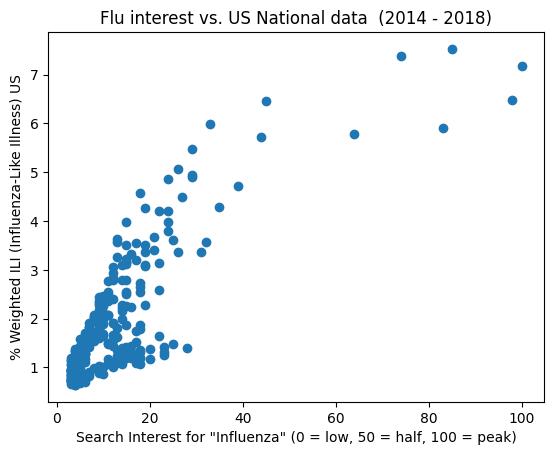

In [16]:
plt.scatter(flu_interest[flu_query], flu_data['% WEIGHTED ILI'])
plt.title('Flu interest vs. US National data  (2014 - 2018)')
plt.xlabel('Search Interest for \"Influenza\" (0 = low, 50 = half, 100 = peak)')
plt.ylabel('% Weighted ILI (Influenza-Like Illness) US')
plt.show()


## 3.2 Measure Pearson’s correlation

In the following chunk, calculate Pearson’s correlation coefficient between `flu interest` and `% WEIGHTED ILI`.

For this you can use the [`pearsonr`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) method of `scipy`.

In [19]:
pearson_flu= stats.pearsonr(flu_interest[flu_query], flu_data['% WEIGHTED ILI'])
print(pearson_flu)


PearsonRResult(statistic=0.8116373428736092, pvalue=2.073516794844066e-62)


## 3.3 Measure correlation after shuffling

What happens if we permute the data (e.g. shuffle the `flu interest`s) and repeat the above analysis? Do you find any difference between the two plots and two Pearson’s correlation coefficients?

For the shuffeling you can use `pandas` [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) method with `frac` set to 1.

This test shows you if the correlation is happend by random.

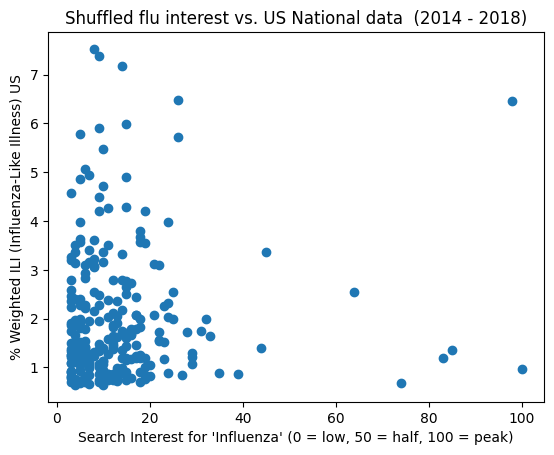

PearsonRResult(statistic=0.051581812956782706, pvalue=0.4066052528374276)


In [20]:
flu_interest_shuffled = flu_interest
flu_interest_shuffled[flu_query] = flu_interest_shuffled[flu_query].sample(frac=1).values

plt.scatter(flu_interest_shuffled[flu_query], flu_data['% WEIGHTED ILI'])
plt.title('Shuffled flu interest vs. US National data  (2014 - 2018)')
plt.xlabel('Search Interest for \'Influenza\' (0 = low, 50 = half, 100 = peak)')
plt.ylabel('% Weighted ILI (Influenza-Like Illness) US')
plt.show()

pearson_flu_shuffled = stats.pearsonr(flu_interest_shuffled[flu_query], flu_data['% WEIGHTED ILI'])
print(pearson_flu_shuffled)

Repeat the calculation with 1000 permutations and plot the histogram of the resulting values. Add a line with the value of the correlation without permutation. Is it far or close to the permuted values?

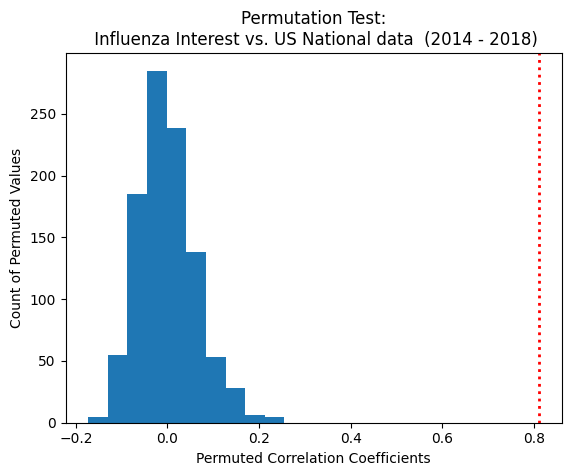

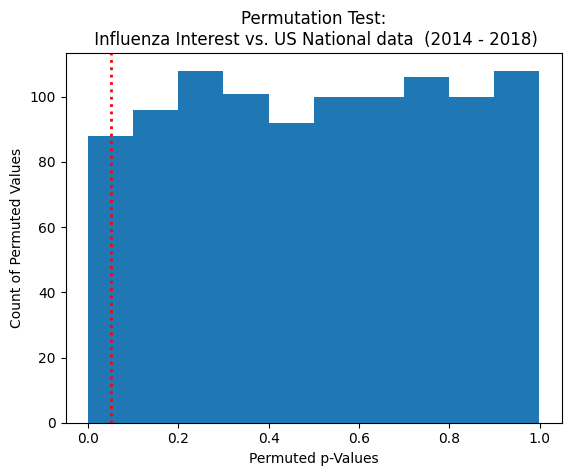

In [22]:
# Permutation Test

flu_interest_shuffled = flu_interest
pearson_flu_statistics = []
pearson_flu_pvalues = []


for i in range(0, 999):
    flu_interest_shuffled[flu_query] = flu_interest_shuffled[flu_query].sample(frac=1).values
    pearson_flu_shuffled = stats.pearsonr(flu_interest_shuffled[flu_query], flu_data['% WEIGHTED ILI'])
    pearson_flu_statistics.append(pearson_flu_shuffled.statistic)
    pearson_flu_pvalues.append(pearson_flu_shuffled.pvalue)
    i += 1

# correlation coefficients
# print(pearson_flu_statistics)
plt.hist(pearson_flu_statistics)
plt.axvline(pearson_flu.statistic, color='r', linestyle = 'dotted', linewidth=2)
plt.title('Permutation Test:\n Influenza Interest vs. US National data  (2014 - 2018)')
plt.xlabel('Permuted Correlation Coefficients')
plt.ylabel('Count of Permuted Values')
plt.show()


# p-Values
# print(pearson_flu_pvalues)
plt.hist(pearson_flu_pvalues)
plt.axvline(0.05, color='r', linestyle='dotted', linewidth=2)
plt.title('Permutation Test:\n Influenza Interest vs. US National data  (2014 - 2018)')
plt.xlabel('Permuted p-Values')
plt.ylabel('Count of Permuted Values')
plt.show()

The permutation test shows nearly a Gaussian distribution of correlation coefficients ranging approximately from -0.2 to 0.2. The coefficient above 0.8 lies very far outside this range, further supporting the assumption that it is not a random correlation.

The analysis of the p-values also leads to this assumption in this case.

In [82]:
# count number of significant results (p-Value <= 0.05) in Permutation Test
significant_permutations_flu = 0

for j in range(0, 999):
    if pearson_flu_pvalues[j] <= 0.05:
        significant_permutations_flu += 1

print(significant_permutations_flu)


49


### To learn more

#### Prediction
* Download the Google Trends data for 2019, and use your models to predict the values of `% WEIGHTED ILI`.
* Do the models make good predictions? Which model performs better?